In [1]:
%matplotlib inline

In [2]:
# PREP========================================================================
# load up arm parameters arm_params and some helper functions
from twojointarm_funs import *

# get ready to plot stuff
import matplotlib.pyplot as plt

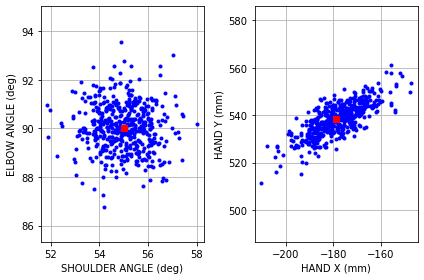

In [18]:
# KINEMATICS==================================================================
# Add noise to joint angles and examine distribution of hand positions
# ============================================================================

A1 = np.array([55,90]) * np.pi/180   # 55,90 degrees shoudler,elbow
H1,_ = joints_to_hand(A1, arm_params)
n_perts = 500
A = np.zeros((n_perts, 2))
H = np.zeros((n_perts, 2))
r = 1.0 * np.pi / 180 # random perts: gaussian with 1 degree sd
for i in range(n_perts):
	A[i,:] = A1 + np.random.randn(2) * r
	H[i,:],_ = joints_to_hand(A[i,:], arm_params)

# make a plot
f = plt.figure()
a1 = f.add_subplot(1,2,1)
a1.plot(A[:,0]*180/np.pi, A[:,1]*180/np.pi, 'b.')
a1.plot(A1[0]*180/np.pi, A1[1]*180/np.pi, 'rs')
a1.set_xlabel('SHOULDER ANGLE (deg)')
a1.set_ylabel('ELBOW ANGLE (deg)')
a1.axis('equal')
a1.grid('on')
a2 = f.add_subplot(1,2,2)
a2.plot(H[:,0]*1000, H[:,1]*1000, 'b.')
a2.plot(H1[0]*1000, H1[1]*1000, 'rs')
a2.set_xlabel('HAND X (mm)')
a2.set_ylabel('HAND Y (mm)')
a2.axis('equal')
a2.grid('on')
f.tight_layout()

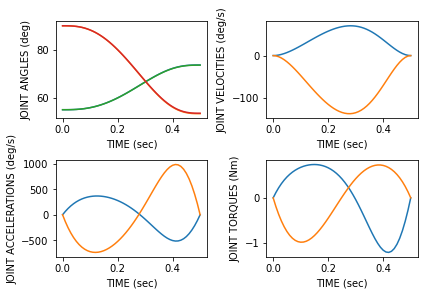

In [19]:
# DYNAMICS====================================================================
# Add noise to joint torques and examine distribution of trajectory endpoint
# ============================================================================

A1 = np.array([55,90]) * np.pi/180   # 55,90 degrees shoudler,elbow
H1,E1 = joints_to_hand(A1, arm_params)
H2 = H1 + np.array([0, 0.15])        # 15 cm movement distance
mt = 0.500                           # movement time (sec)
sr = 100                             # sample rate (Hz)
npts = np.int(mt*sr)+1               # number of time points

# get a minimum-jerk desired hand trajectory
t,H,Hd,Hdd = minjerk(H1,H2,mt,npts)

# get corresponding desired joint angles velocities and accelerations
A,Ad,Add = hand_to_joints((H,Hd,Hdd),arm_params)

# compute required joint torques
Q = inverse_dynamics(A,Ad,Add,arm_params)

# run a forward simulation using those joint torques Q
A0, Ad0 = A[0,:], Ad[0,:] # starting joint angles and velocities
A_sim, Ad_sim, Add_sim = forward_dynamics(A0, Ad0, Q, t, arm_params)

# make some plots

f0 = plt.figure()
ax = f0.add_subplot(2,2,1)
lines = ax.plot(t,A*180/np.pi)
lines2= ax.plot(t,A_sim*180/np.pi)
ax.set_xlabel('TIME (sec)')
ax.set_ylabel('JOINT ANGLES (deg)')
ax = f0.add_subplot(2,2,2)
lines = ax.plot(t,Ad*180/np.pi)
ax.set_xlabel('TIME (sec)')
ax.set_ylabel('JOINT VELOCITIES (deg/s)')
ax = f0.add_subplot(2,2,3)
lines = ax.plot(t,Add*180/np.pi)
ax.set_xlabel('TIME (sec)')
ax.set_ylabel('JOINT ACCELERATIONS (deg/s)')
ax = f0.add_subplot(2,2,4)
lines = ax.plot(t,Q)
ax.set_xlabel('TIME (sec)')
ax.set_ylabel('JOINT TORQUES (Nm)')
f0.tight_layout()

(-188.4943025651281, -167.75306125320037, 672.229635388469, 704.9736002820125)

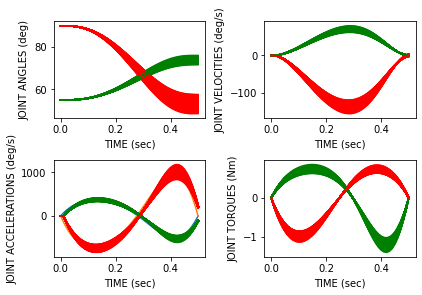

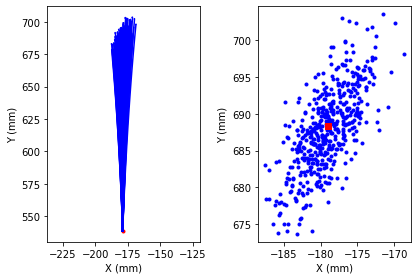

In [20]:
# ============================================================================
# Forward simulations with random amplification or diminishment of 
# shoulder and elbow torques

# re-draw simulated movement from above

f1 = plt.figure()
f1ax1 = f1.add_subplot(2,2,1)
lines = f1ax1.plot(t,A*180/np.pi)
f1ax1.set_xlabel('TIME (sec)')
f1ax1.set_ylabel('JOINT ANGLES (deg)')
f1ax2 = f1.add_subplot(2,2,2)
lines = f1ax2.plot(t,Ad*180/np.pi)
f1ax2.set_xlabel('TIME (sec)')
f1ax2.set_ylabel('JOINT VELOCITIES (deg/s)')
f1ax3 = f1.add_subplot(2,2,3)
lines = f1ax3.plot(t,Add*180/np.pi)
f1ax3.set_xlabel('TIME (sec)')
f1ax3.set_ylabel('JOINT ACCELERATIONS (deg/s)')
f1ax4 = f1.add_subplot(2,2,4)
lines = f1ax4.plot(t,Q)
f1ax4.set_xlabel('TIME (sec)')
f1ax4.set_ylabel('JOINT TORQUES (Nm)')
f1.tight_layout()

H,_ = joints_to_hand(A, arm_params)

f2 = plt.figure()
f2ax1 = f2.add_subplot(1,2,1)
f2ax2 = f2.add_subplot(1,2,2)
f2ax1.plot(H[0,0]*1000,H[0,1]*1000,'r.')
f2ax2.plot(H[-1,0]*1000,H[-1,1]*1000,'rs')
f2ax1.set_xlabel('X (mm)')
f2ax2.set_xlabel('X (mm)')
f2ax1.set_ylabel('Y (mm)')
f2ax2.set_ylabel('Y (mm)')
f2.tight_layout()

# re-do forward simulations and randomly (gaussian) amplify or diminish
# joint torques within a given range, and replot. In particular example
# hand endpoint distribution

n_perts = 500

for i in range(n_perts):
	print("perturbation {0} of {1}".format(i+1,n_perts), end="\r")
	QQ = np.copy(Q)
	QQ[:,0] = QQ[:,0] * (0.05*np.random.randn()+1.0) # mean 1.0, sd 0.05
	QQ[:,1] = QQ[:,1] * (0.05*np.random.randn()+1.0)
	A0, Ad0 = A[0,:], Ad[0,:] # starting joint angles and velocities
	A_sim, Ad_sim, Add_sim = forward_dynamics(A0, Ad0, QQ, t, arm_params)
	f1ax1.plot(t,A_sim[:,0]*180/np.pi,'g-')
	f1ax1.plot(t,A_sim[:,1]*180/np.pi,'r-')
	f1ax2.plot(t,Ad_sim[:,0]*180/np.pi,'g-')
	f1ax2.plot(t,Ad_sim[:,1]*180/np.pi,'r-')
	f1ax3.plot(t,Add_sim[:,0]*180/np.pi,'g-')
	f1ax3.plot(t,Add_sim[:,1]*180/np.pi,'r-')
	f1ax4.plot(t,QQ[:,0],'g-')
	f1ax4.plot(t,QQ[:,1],'r-')
	H_sim,_ = joints_to_hand(A_sim, arm_params)
	f2ax1.plot(H_sim[:,0]*1000,H_sim[:,1]*1000,'b-')
	f2ax2.plot(H_sim[-1,0]*1000,H_sim[-1,1]*1000,'b.')
f2ax2.plot(H[-1,0]*1000,H[-1,1]*1000,'rs')
f2ax1.axis('equal')
f2ax2.axis('equal')